---

## Facet: Facial Expressions in iMotions's Software Suite

The facial expressions facet in iMotions's software suite harnesses advanced computer vision and machine learning techniques to detect, measure, and analyze facial movements. This module is pivotal for understanding emotional and behavioral responses in real-time.

### Modality
- **Type:** Visual (Video/Image)
- **Purpose:**
  - Decodes subtle facial cues and micro-expressions
  - Provides real-time insights into emotional and affective states
  - Supports a variety of research and practical applications, from consumer behavior analysis to psychological studies

### Feature Extraction
- **Pre-processing:**
  - Implements robust facial landmark detection and alignment to ensure accuracy
- **Analysis:**
  - Utilizes the Facial Action Coding System (FACS) to quantify muscle activations
  - Measures expression intensity, duration, and frequency for comprehensive emotion profiling
- **Applications:**
  - Market research and advertising to gauge consumer reactions
  - Psychological and behavioral studies to analyze emotional responses
  - Human-computer interaction (HCI) to improve user experience and adaptive interfaces

---

### Importing Libraries

In [1]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import (
	Conv2D,
	MaxPooling2D,
	AveragePooling2D,
	Flatten,
	Dense,
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

/Users/alexanderhsu/Documents/GitHub/11777-EMOji/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### Loading Data Tensors

In [2]:
with open('../data/tensors.pkl', 'rb') as fr:
    data_tensors = pickle.load(fr)

### Prepare Data into Partitions that make sense

In [3]:
partitions_ = data_tensors[1]
data_all = data_tensors[0]
data_partitions = {partitions_[0]: data_all[0], partitions_[1]: data_all[1], partitions_[2]: data_all[2]}


In [4]:
data_partitions['train'].keys()

dict_keys(['COAVAREP', 'FACET 4.2', 'OpenFace_2.0', 'All Labels', 'glove_vectors', 'OpenSMILE'])

In [6]:
data_partitions['train']['FACET 4.2'].shape

(16327, 50, 35)

### Exploring Training Data Distribution

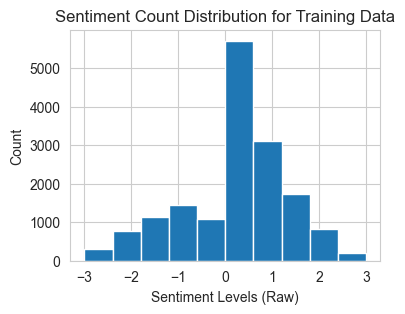

In [7]:
# looking at sentiment probability distribution in train
fig, ax = plt.subplots(figsize=(4, 3))
ax.hist(data_partitions['train']['All Labels'][:, :, 0])
ax.set_xlabel("Sentiment Levels (Raw)")
ax.set_ylabel("Count")
ax.set_title('Sentiment Count Distribution for Training Data')
plt.show()

### Extract glove_vectors Only

In [9]:
for k in data_partitions['train'].keys():
    if k == 'FACET 4.2':
        X_train = data_partitions['train'][k]
        X_test = data_partitions['test'][k]
        X_val = data_partitions['valid'][k]
        print(f'{k} has dimension {X_train.shape[1:]}')

FACET 4.2 has dimension (50, 35)


### Preparing Labels for Training, Testing, and Validation

In [10]:
emo_selected = 0 # sentiment
Y_train = data_partitions['train']['All Labels'][:, :, emo_selected]
Y_test = data_partitions['test']['All Labels'][:, :, emo_selected]
Y_val = data_partitions['valid']['All Labels'][:, :, emo_selected]

# Round the values to the nearest integer
Y_train_rounded = np.round(Y_train).astype(int)
Y_test_rounded = np.round(Y_test).astype(int)
Y_val_rounded = np.round(Y_val).astype(int)

# If you need class indices from 0 to 6 instead of -3 to 3, you can shift them:
Y_train_classes = Y_train_rounded + 3
Y_test_classes = Y_test_rounded + 3
Y_val_classes = Y_val_rounded + 3

print(Y_train_classes.shape, Y_test_classes.shape, Y_val_classes.shape)

(16327, 1) (4662, 1) (1871, 1)


/var/folders/gp/nsk60k_n2cz7kk79_pv33d8r0000gn/T/ipykernel_8639/1000670048.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(np.arange(-3, 3.1).astype(int))


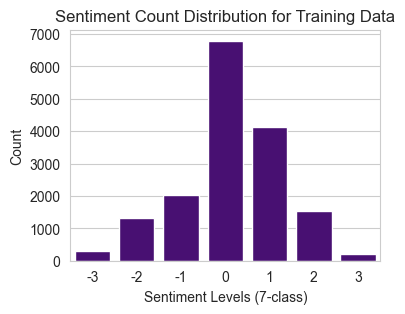

In [26]:
# If Y_train_classes is multidimensional, flatten it to 1D
y_train_flat = Y_train_classes.flatten()

# Create the countplot
fig, ax = plt.subplots(figsize=(4, 3))
sns.countplot(x=y_train_flat, ax=ax, color='indigo')
ax.set_xlabel("Sentiment Levels (7-class)")
ax.set_xticklabels(np.arange(-3, 3.1).astype(int))
ax.set_ylabel("Count")
ax.set_title('Sentiment Count Distribution for Training Data')
plt.show()
fig.savefig('../figures/sentiment_count_distribution_train.png',
			bbox_inches='tight', dpi=300)

### Building the CNN Model

In [12]:
input_dim_1 = X_train.shape[1]
input_dim_2 = X_train.shape[2]
# since classes are: -3, -2, -1, 0, 1, 2, 3 (or 0-6 after shifting)
num_classes = 7

model = Sequential()

# 1st convolution layer
model.add(Conv2D(64, (5, 5), activation="relu",
                 input_shape=(input_dim_1, input_dim_2, 1)))
model.add(MaxPooling2D(pool_size=(5, 5), strides=(2, 2)))

# 2nd convolution layer
model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(AveragePooling2D(pool_size=(3, 3), strides=(2, 2)))

model.add(Flatten())

# Classification output layer: 7 neurons with softmax activation
model.add(Dense(num_classes, activation="softmax"))
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

/Users/alexanderhsu/Documents/GitHub/11777-EMOji/venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Preparing Data for Model Training

In [13]:
X_train_reshape = X_train.reshape(-1, input_dim_1, input_dim_2, 1)
Y_train_reshape = np.array(Y_train_classes).reshape(-1, 1)
X_test_reshape = X_test.reshape(-1, input_dim_1, input_dim_2, 1)
Y_test_reshape = np.array(Y_test_classes).reshape(-1, 1)
X_val_reshape = X_val.reshape(-1, input_dim_1, input_dim_2, 1)
Y_val_reshape = np.array(Y_val_classes).reshape(-1, 1)

# there could be some inf values in features
# Replace Inf values with the max finite value in X_data
X_train_reshape[np.isinf(X_train_reshape)] = np.nan 
X_train_reshape = np.nan_to_num(X_train_reshape, nan=np.nanmax(X_train_reshape)) 
# Replace Inf values with the max finite value in X_data
X_test_reshape[np.isinf(X_test_reshape)] = np.nan 
X_test_reshape = np.nan_to_num(X_test_reshape, nan=np.nanmax(X_test_reshape)) 
# Replace Inf values with the max finite value in X_data
X_val_reshape[np.isinf(X_val_reshape)] = np.nan 
X_val_reshape = np.nan_to_num(X_val_reshape, nan=np.nanmax(X_val_reshape))

### Training the Model

In [14]:
history = model.fit(X_train_reshape, 
                    Y_train_reshape, 
                    epochs=200,       # Adjust as needed
                    batch_size=32,   # Adjust based on available memory
                    validation_data=(X_val_reshape, Y_val_reshape),
                    verbose=2)


Epoch 1/200
511/511 - 8s - 16ms/step - accuracy: 0.4147 - loss: 1.5435 - val_accuracy: 0.4538 - val_loss: 1.4500
Epoch 2/200
511/511 - 7s - 15ms/step - accuracy: 0.4230 - loss: 1.4967 - val_accuracy: 0.4543 - val_loss: 1.4452
Epoch 3/200
511/511 - 8s - 15ms/step - accuracy: 0.4271 - loss: 1.4821 - val_accuracy: 0.4522 - val_loss: 1.4493
Epoch 4/200
511/511 - 8s - 15ms/step - accuracy: 0.4257 - loss: 1.4728 - val_accuracy: 0.4532 - val_loss: 1.4389
Epoch 5/200
511/511 - 7s - 14ms/step - accuracy: 0.4263 - loss: 1.4677 - val_accuracy: 0.4554 - val_loss: 1.4393
Epoch 6/200
511/511 - 7s - 14ms/step - accuracy: 0.4307 - loss: 1.4587 - val_accuracy: 0.4500 - val_loss: 1.4293
Epoch 7/200
511/511 - 7s - 14ms/step - accuracy: 0.4299 - loss: 1.4542 - val_accuracy: 0.4538 - val_loss: 1.4465
Epoch 8/200
511/511 - 7s - 14ms/step - accuracy: 0.4309 - loss: 1.4477 - val_accuracy: 0.4564 - val_loss: 1.4312
Epoch 9/200
511/511 - 7s - 14ms/step - accuracy: 0.4324 - loss: 1.4417 - val_accuracy: 0.4511 - 

In [15]:
# Save the entire model (architecture, weights, and optimizer state)
model.save("../models/facet_unimodal_baseline_model.h5")

### Evaluating Model - Predictions and Metrics

In [16]:
y_predict = np.argmax(model.predict(X_test_reshape), axis=1)

146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [17]:
# Compute the confusion matrix
cm = confusion_matrix(Y_test_reshape, y_predict, normalize='true')

# Compute precision, recall, and f1-score using classification_report
report = classification_report(Y_test_reshape, y_predict)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.09      0.07      0.08        70
           1       0.12      0.12      0.12       399
           2       0.13      0.10      0.11       554
           3       0.43      0.56      0.49      1927
           4       0.31      0.24      0.27      1230
           5       0.15      0.11      0.13       441
           6       0.03      0.02      0.03        41

    accuracy                           0.33      4662
   macro avg       0.18      0.18      0.18      4662
weighted avg       0.30      0.33      0.31      4662



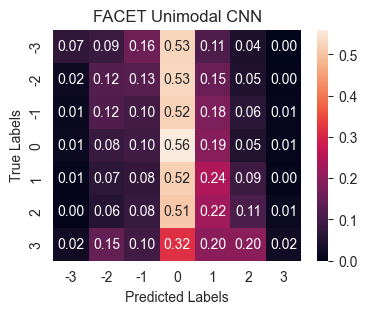

In [25]:
fig, ax = plt.subplots(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt=".2f", xticklabels=np.arange(-3, 3.1).astype(int),
			yticklabels=np.arange(-3, 3.1).astype(int), ax=ax)
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
ax.set_title("FACET Unimodal CNN")
# ax.set_xticklabels(np.arange(-3, 3.1))
plt.show()
fig.savefig('../figures/facet_unimodal_baseline_confusion_matrix.png', bbox_inches='tight', dpi=300)